In [1]:
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, get_bag_of_words
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import zipfile
import pickle
import nltk
import tqdm
import re
import numpy as np
import gensim
import spacy
import os
import matplotlib.pyplot as plt
import keras
from gensim.corpora import Dictionary
import copy
from gensim.utils import simple_preprocess

# WIP code part
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from nltk.corpus import stopwords as stop_words

nltk.download('stopwords')
# load the pre-trained English language model
nlp = spacy.load('en_core_web_sm')

custom_stopwords = set(stop_words.words("english"))
custom_stopwords = custom_stopwords.union({"reuters", "bbc"})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kreti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# The same one as in the test_environment.py
def progress_bar(iteration, total):
    total_len = 100
    percent_part = ("{0:.2f}").format(100 * (iteration / total))
    filled = int(total_len * iteration / total)
    bar = '█' * filled + '-' * (total_len - filled)
    print(f'\r Progress: [{bar}] {percent_part}%', end='')
    if iteration == total:
        print()

## Data preprocessing

In [3]:
def process_file(file, filename, texts):
    content = file.read(filename)
    if type(content) == bytes:
        text = content.decode('utf-8')
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
        for sentence in sentences:
            texts.append(sentence)

    if len(content.strip()) == 0:
        print("No text was found")
        return

In [4]:
def process_docs(docs):
    # simple preprocessing that removes stopwords and punctuation
    sp = WhiteSpacePreprocessingStopwords(docs, min_words=3, stopwords_list=custom_stopwords)

    # this function returns the pre and the unpre processed documents and a vocab with the most frequent 2K tokens
    # these tokens are going to be used to represent the topics
    preprocessed_documents, unpreprocessed_documents, vocab, retained_indices = sp.preprocess() 
    return preprocessed_documents, vocab, retained_indices

In [5]:
# ner_model_mode: model we want to use
#     - specific_lstm: BiLSTM model trained on CORD19 data
#     - general_lstm: BiLSTM model trained on general (topics) data
#     - specific_transformer: Transformer-based model trained on CORD19 data
#     - general_transformer:Transformer-based model trained on general (topics) data
def load_ner(ner_model_mode):
    if ner_model_mode == "specific_lstm":
        pass
    elif ner_model_mode == "general_lstm":
        pass
    elif ner_model_mode == "specific_transformer":
        model = keras.models.load_model('../models/model_cord_transformer/model.tf')

        with open('../models/model_cord_transformer/maxlen.pickle', 'rb') as handle:
            max_len = pickle.load(handle)

        with open('../models/model_cord_transformer/tags.pickle', 'rb') as handle:
            tags = pickle.load(handle)

        with open('../models/model_cord_transformer/words.pickle', 'rb') as handle:
            word2idx = pickle.load(handle)
        
        return model, tags, word2idx, max_len
    elif ner_model_mode == "general_transformer":
        model = keras.models.load_model('../models/model_general_transformer/model.tf')

        with open('../models/model_general_transformer/maxlen.pickle', 'rb') as handle:
            max_len = pickle.load(handle)

        with open('../models/model_general_transformer/tags.pickle', 'rb') as handle:
            tags = pickle.load(handle)

        with open('../models/model_general_transformer/words.pickle', 'rb') as handle:
            word2idx = pickle.load(handle)
        
        return model, tags, word2idx, max_len
    else:
        return None, None, None, None

In [6]:
def ner_words2idx(text, word2idx, max_len, endpad_idx):
    # Convert the tokens to integer IDs using the word2id dictionary
    idxs = []
    array = []
    for token in text:
        if token in word2idx.keys():
            array.append(word2idx[token])
        else:
            array.append(0)

    while len(array) < max_len:
        array.append(endpad_idx)
    idxs.append(array)

    return idxs

In [7]:
def extract_named_entities(texts, model, tags, word2idx, max_len, ignored_entities, max_texts):
    # init variables
    ents = []
    labels = []
    idxs = []
    
    if ignored_entities:
        pattern_string = ".*-(" + "|".join(ignored_entities) + ")|Other|O"
    else:
        pattern_string = "Other|O"
    pattern = re.compile(pattern_string)
    endpad_idx = word2idx['endpad']
    
    for text in texts[:max_texts]:
        # transform words to idx to be processed by NER 
        idxs.append(ner_words2idx(text, word2idx, max_len, endpad_idx)[0])

    # predict label, and add to the found entities list
    p = model.predict(np.array(idxs), verbose=0)
    p = np.argmax(p, axis=-1)
    for text_idx, text in enumerate(texts[0:max_texts]):
        for idx, pred in enumerate(p[text_idx][0:max_texts]):
            # add named entity to the entities list if is not endpad and is not ignored
            if not pattern.match(tags[pred]):
                ents.append(text[idx].lower())
                labels.append(tags[pred])
        
#     ents = remove_stopwords(ents)
    return ents, labels

In [8]:
def create_named_entity_clusters(entities, labels):
    
    # removes 'B-' and 'I-' prefix from entity labels
    def remove_prefix(label):
        return label.split('-')[-1]

    entity_clusters = {}
    for entity, label in zip(entities, labels):
        if (general_label := remove_prefix(label)) in entity_clusters.keys():
            entity_clusters[general_label].append(entity)
        else:
            entity_clusters[general_label] = [entity]
    
    # delete small clusters with less than 10 words
    for key in entity_clusters.keys():
        if len(entity_clusters[key]) < 10:
            entity_clusters[key] = []
            
    return entity_clusters

In [9]:
def preprocess_files_from_zip(arch_path, ner_model_mode, ignored_entities=[], max_texts=0):
    texts = []
    
    with zipfile.ZipFile(arch_path, "r") as f:
        total_f = len(f.namelist())
        counter = 1
        for filename in f.namelist():
            counter += 1
            process_file(f, filename, texts)
        f.close()
        
    if texts:
        processed_docs, vocab, idxs = process_docs(texts)
        tokenized_docs = [nltk.word_tokenize(sentence) for sentence in processed_docs]
        # limit observed documents if number is provided as argument
        max_texts = len(tokenized_docs) if not max_texts else max_texts
        ner, tags, word2idx, max_len = load_ner(ner_model_mode)
        # change keys in the NER dictionary to lowercase
        word2idx_lowercase = {key.lower(): value for key, value in word2idx.items() if type(key) == str}
        if ner:
            ents, labels = extract_named_entities(tokenized_docs, ner, tags, word2idx_lowercase, max_len, ignored_entities, max_texts)
            
            # create a dictionary mapping named entities to integer ids
            dictionary = Dictionary(tokenized_docs)

            # create a document-term matrix where each document is a text and each term is a named entity
            corpus = [text for text in tokenized_docs[:max_texts]]
            
            # create named entity clusters
            entity_clusters = create_named_entity_clusters(ents, labels)
            
        return corpus, dictionary, entity_clusters

In [10]:
ignored_labels = ["MONEY", "QUANTITY", "PERCENT", "ORDINAL", "DATE", "TIME",  "CARDINAL"]
# corpus, dictionary, entity_clusters = preprocess_files_from_zip(
#     "../data/articles_2021-11-05_1000.zip", 
#     "general_transformer", 
#     ignored_labels,
#     3000
# )
corpus, dictionary, entity_clusters = preprocess_files_from_zip(
    "../data/articles_2023-02-04_500.zip", 
    "specific_transformer", 
    ignored_labels,
    3000
)

In [11]:
len(entity_clusters.keys())

28

In [12]:
def list_to_2d_array(input_list, chunk_size):
    divided_array = []
    for i in range(0, len(input_list), chunk_size):
        chunk = input_list[i:i + chunk_size]
        divided_array.append(chunk)
    return divided_array

In [13]:
# create artificial documents from named entities and add them to corpus
corpus_extended = copy.deepcopy(corpus)
corpus_len = len(corpus)

# coefficient used to determine number of artificial articles per label relative to the size of corpus (number of texts)
multiplication_coef = 0.5/len(entity_clusters.keys())
print("multiplier per label: " + str(multiplication_coef))

# add named entities to dictionary and corpus
for entity_type, entities in entity_clusters.items():
    if len(entities) > 5:
        processed_ents = [simple_preprocess(entity.lower())[0] for entity in set(entities)]
        new_docs = list_to_2d_array(processed_ents, 32)
        for i in range(int(corpus_len*multiplication_coef/len(new_docs))):
            for doc in new_docs:
                corpus_extended.append(doc)
            
#         for i in range(int(corpus_len*multiplication_coef)):
#             corpus_extended.append(new_doc)

print(len(corpus), len(corpus_extended))

multiplier per label: 0.017857142857142856
3000 4004


In [14]:
corpus[-1]

['increased',
 'blood',
 'flow',
 'associated',
 'disease',
 'brain',
 'well',
 'produce',
 'chemical',
 'called',
 'brain',
 'factor',
 'brain',
 'cells']

In [15]:
corpus_extended[-1]

['harder', 'seeds', 'trees', 'leaves', 'dogs', 'humans', 'moss']

In [16]:
string_corpus = [' '.join(tokens) for tokens in corpus]
string_corpus_extended = [' '.join(tokens) for tokens in corpus_extended]
string_corpus[:2]

['people low sex drive could benefit hormone called according clinical trials found boost sexual responses',
 'trials first show hormone increase activity brain linked men women low']

## ---------

In [17]:
texts = []
max_len = False
# with zipfile.ZipFile("../data/articles_2021-11-05_1000.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-01-07_2000.zip", "r") as f:
with zipfile.ZipFile("../data/articles_2023-02-04_500.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-02-09_1000.zip", "r") as f:
    total_f = len(f.namelist())
    counter = 1
    for filename in f.namelist():
        counter += 1
        process_file(f, filename, texts)
    f.close()

texts[:2]

['People with a low sex drive could benefit from injections of a hormone called kisspeptin, according to clinical trials that found the shots can boost sexual responses.',
 'The trials are the first to show the hormone can increase activity in brain regions linked to arousal and attraction in men and women who are distressed by their low libidos.']

In [18]:
stopwords = list(stop_words.words("english"))

# simple preprocessing that removes stopwords and punctuation
sp = WhiteSpacePreprocessingStopwords(string_corpus_extended, min_words=3, stopwords_list=stopwords)

# this function returns the pre and the unpre processed documents and a vocab with the most frequent 2K tokens
# these tokens are going to be used to represent the topics
preprocessed_documents, unpreprocessed_documents, vocab, retained_indices = sp.preprocess() 

In [19]:
preprocessed_documents[:2]

['people low sex drive could benefit hormone called according clinical trials found boost sexual responses',
 'trials first show hormone increase activity brain linked men women low']

In [20]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased", max_seq_length=32) # instantiate a contextualized model

# create the training set
training_dataset = tp.fit(text_for_contextual=string_corpus, text_for_bow=string_corpus)

training_dataset

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\utils\data_preparation.py:64: UserWarning: the longest document in your collection has 54 words, the model instead truncates to 32 tokens.
  warnings.warn(


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [21]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased", max_seq_length=32) # instantiate a contextualized model

# create the training set
training_dataset_extended = tp.fit(text_for_contextual=string_corpus_extended, text_for_bow=string_corpus_extended)

training_dataset_extended

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\utils\data_preparation.py:64: UserWarning: the longest document in your collection has 54 words, the model instead truncates to 32 tokens.
  warnings.warn(


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [22]:
word2id = {}
id2word = {}
for key, val in zip(vocab, retained_indices):
    word2id[key] = val
    id2word[val] = key

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model training, saving, loading

In [23]:
# Not used yet in the experiment, WIP
def train_lda(num_topics):
    # Create the LDA model
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=num_topics,
                                workers=19,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                iterations=200,
                                alpha='symmetric',
                                per_word_topics=False
                                )
    return lda_model

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
def train_ntm_model(save_dir, num_topics=5, dataset=training_dataset):
    ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=5, batch_size=64)
    ctm.fit(dataset) # run the model
    ctm.save(models_dir=save_dir)    
    return ctm

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Metrics and evaluation

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_tus(model, words_num, num_topics, is_lda):
    """
    Calculate Topic Uniqueness Score (TUS) for each topic in a given LDA model.
    Returns an array of TUS scores and a mean TUS score for a model.
    The lower TUS score means that topics are less similar <-> more unique.
    """
    words_num = model.bow_size
#     words_num = 100
    num_topics = model.n_components
    word_probs = np.zeros((num_topics, words_num))
    for topic_id in range(num_topics):
        if is_lda:
            word_probs[topic_id, :] = np.array([p for _, p in model.get_topic_terms(topic_id, words_num)])
        else:
            word_probs[topic_id, :] = np.array([p for _, p in model.get_word_distribution_by_topic_id(topic_id)])
    
    similarities = cosine_similarity(word_probs)
    np.fill_diagonal(similarities, 0) # set diagonal to 0 so a topic is not compared with itself
    tus_scores = np.mean(similarities, axis=1)
    tus_mean = np.mean(tus_scores)
    return tus_scores, tus_mean

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
from scipy.spatial import distance

def calc_hausdorff_distance(model, num_topics, is_lda):
    hd_matrix = np.zeros((num_topics, num_topics))  # initialize a matrix to store HD values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            if is_lda:
                topic_i_dist = model.get_topic_terms(i)
                topic_j_dist = model.get_topic_terms(j)
            else:
                # open-source ctm implementation does not limit number of words, so we have to limit it to the top-8 manually
                topic_i_dist = [[word2id[p]] for p, _ in model.get_word_distribution_by_topic_id(i)[:8]]
                topic_j_dist = [[word2id[p]] for p, _ in model.get_word_distribution_by_topic_id(j)[:8]]

            # compute asymmetric Hausdorff distance (HD) by saving the biggest of the two
            hd = max(distance.directed_hausdorff(topic_i_dist, topic_j_dist), 
                      distance.directed_hausdorff(topic_j_dist, topic_i_dist))

            hd_matrix[i, j] = hd[0]

    return np.mean(hd_matrix)

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
from scipy.spatial.distance import jensenshannon

def calc_jansen_shannon_divergence(model, num_topics, is_lda):
    js_matrix = np.zeros((num_topics, num_topics))  # Initialize a matrix to store JS values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            topic_i_dist = [[p] for _, p in model.get_word_distribution_by_topic_id(i)[:10]]
            topic_j_dist = [[p] for _, p in model.get_word_distribution_by_topic_id(j)[:10]]

            js_divergence = jensenshannon(topic_i_dist, topic_j_dist)

            js_matrix[i, j] = js_divergence

    return np.mean(js_matrix)

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
results = {'tus': {}, 'js': {}}
corpuses = ["ntm", "ner_ntm"]
num_topics_arr = [5, 10, 15, 20]

def do_test():
    total_iter = len(corpuses) * len(num_topics_arr)
    curr_iter = 1
    for key in corpuses:
        results['tus'][key] = {}
        results['js'][key] = {}
        for num_topics in num_topics_arr:
            progress_bar(curr_iter, total_iter)
            if key=='ntm':
                dir_path = f"../models/ntm_topics{num_topics}_cord/"
                # if directory already exists, model have been saved before
                if os.path.isdir(dir_path):
                    ctm_model = CombinedTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=10, batch_size=64)
                    ctm_model.load(model_dir=dir_path, epoch=4)
                else:
                    ctm_model = train_ntm_model(dir_path, num_topics, training_dataset)
                _, score_tus = calculate_tus(ctm_model, ctm_model.bow_size, ctm_model.n_components, False)
#                 score_hd = calc_hausdorff_distance(ctm_model, ctm_model.n_components, False)
                score_js = calc_jansen_shannon_divergence(ctm_model, ctm_model.n_components, False)
            else:
                dir_path = f"../models/ntm_topics{num_topics}_extended_cord/"
#                 dir_path = f"../models/ntm_topics{num_topics}/"
                # if directory already exists, model have been saved before
                if os.path.isdir(dir_path):
                    ctm_model = CombinedTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=10, batch_size=64)
                    ctm_model.load(model_dir=dir_path, epoch=4)
                else:
                    ctm_model = train_ntm_model(dir_path, num_topics, training_dataset_extended)
                _, score_tus = calculate_tus(ctm_model, ctm_model.bow_size, ctm_model.n_components, False)
#                 score_hd = calc_hausdorff_distance(ctm_model, ctm_model.n_components, False)
                score_js = calc_jansen_shannon_divergence(ctm_model, ctm_model.n_components, False)
            
            results['tus'][key][str(num_topics)] = score_tus
            results['js'][key][str(num_topics)] = score_js
            curr_iter += 1


do_test()

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Progress: [████████████----------------------------------------------------------------------------------------] 12.50%

Epoch: [5/5]	 Seen Samples: [14720/15000]	Train Loss: 62.74389880636464	Time: 0:00:32.403402: : 5it [02:25, 29.16s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:27<00:00,  1.71it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

 Progress: [█████████████████████████---------------------------------------------------------------------------] 25.00%

Epoch: [5/5]	 Seen Samples: [14720/15000]	Train Loss: 65.33793076224948	Time: 0:00:27.545459: : 5it [02:17, 27.57s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.68it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

 Progress: [█████████████████████████████████████---------------------------------------------------------------] 37.50%

Epoch: [5/5]	 Seen Samples: [14720/15000]	Train Loss: 67.68820638241975	Time: 0:00:29.655694: : 5it [02:25, 29.16s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.68it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

 Progress: [██████████████████████████████████████████████████--------------------------------------------------] 50.00%

Epoch: [5/5]	 Seen Samples: [14720/15000]	Train Loss: 70.87743825497834	Time: 0:00:28.562293: : 5it [02:23, 28.65s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.66it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

 Progress: [██████████████████████████████████████████████████████████████--------------------------------------] 62.50%

Epoch: [5/5]	 Seen Samples: [19840/20020]	Train Loss: 62.1509957467356	Time: 0:00:29.607945: : 5it [02:23, 28.61s/it] 
100%|████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:28<00:00,  2.22it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

 Progress: [███████████████████████████████████████████████████████████████████████████-------------------------] 75.00%

Epoch: [5/5]	 Seen Samples: [19840/20020]	Train Loss: 62.6214360883159	Time: 0:00:28.358895: : 5it [02:22, 28.51s/it] 
100%|████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:28<00:00,  2.18it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

 Progress: [███████████████████████████████████████████████████████████████████████████████████████-------------] 87.50%

Epoch: [5/5]	 Seen Samples: [19840/20020]	Train Loss: 64.44924274567634	Time: 0:00:28.779879: : 5it [02:26, 29.32s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:28<00:00,  2.23it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

 Progress: [████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%


Epoch: [5/5]	 Seen Samples: [19840/20020]	Train Loss: 66.60241268527123	Time: 0:00:29.292065: : 5it [02:24, 28.97s/it]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:28<00:00,  2.24it/s]
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  js_matrix[i, j] = js_divergence
<ipython-input-27-52a28710ee82>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wil

In [29]:
results

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'tus': {'ntm': {'5': 0.7999469313784837,
   '10': 0.8998994241834426,
   '15': 0.933277860485164,
   '20': 0.9499459380398962},
  'ner_ntm': {'5': 0.7998340401144003,
   '10': 0.8998151226938166,
   '15': 0.9331565713370809,
   '20': 0.9498374857117036}},
 'js': {'ntm': {'5': 0.001839306764304638,
   '10': 0.0011972248170059173,
   '15': 0.0008243696933560487,
   '20': 0.0009319852766202529},
  'ner_ntm': {'5': 0.0012172740418463946,
   '10': 0.001271455527166836,
   '15': 0.0024049620314811667,
   '20': 0.001445455477005453}}}

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


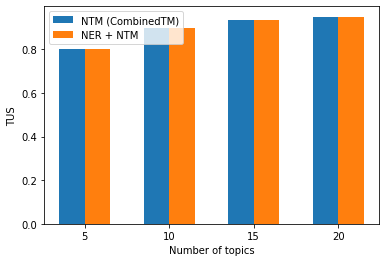

In [30]:
classic_keys = list(results['tus']['ntm'].keys())
extended_keys = list(results['tus']['ner_ntm'].keys())

classic_values = list(results['tus']['ntm'].values())
extended_values = list(results['tus']['ner_ntm'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label='NTM (CombinedTM)')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label='NER + NTM')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "TUS"

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


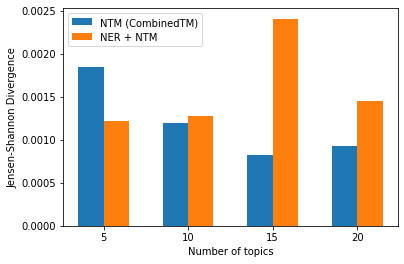

In [31]:
classic_keys = list(results['js']['ntm'].keys())
extended_keys = list(results['js']['ner_ntm'].keys())

classic_values = list(results['js']['ntm'].values())
extended_values = list(results['js']['ner_ntm'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label='NTM (CombinedTM)')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label='NER + NTM')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "Jensen-Shannon Divergence" 

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()